In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# !pip install tfds-nightly
import tensorflow_datasets as tfds

In [3]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files = False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/conda/lib/python3.7/site-packages/u

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteF3RPOE/celeb_a-train.tfrecord


  0%|          | 0/162770 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.1.incompleteF3RPOE/celeb_a-validation.tfrecord


  0%|          | 0/19867 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [4]:
celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

In [5]:
print(f'Train Set example count: {len(celeba_train)}')
print(f'Validation Set example count: {len(celeba_valid)}')
print(f'Test Set example count: {len(celeba_test)}')

Train Set example count: 162770
Validation Set example count: 19867
Test Set example count: 19962


In [6]:
for item in celeba_train.take(5):
    print(type(item))
    print(item['image'].shape)

<class 'dict'>
(218, 178, 3)
<class 'dict'>
(218, 178, 3)
<class 'dict'>
(218, 178, 3)
<class 'dict'>
(218, 178, 3)
<class 'dict'>
(218, 178, 3)


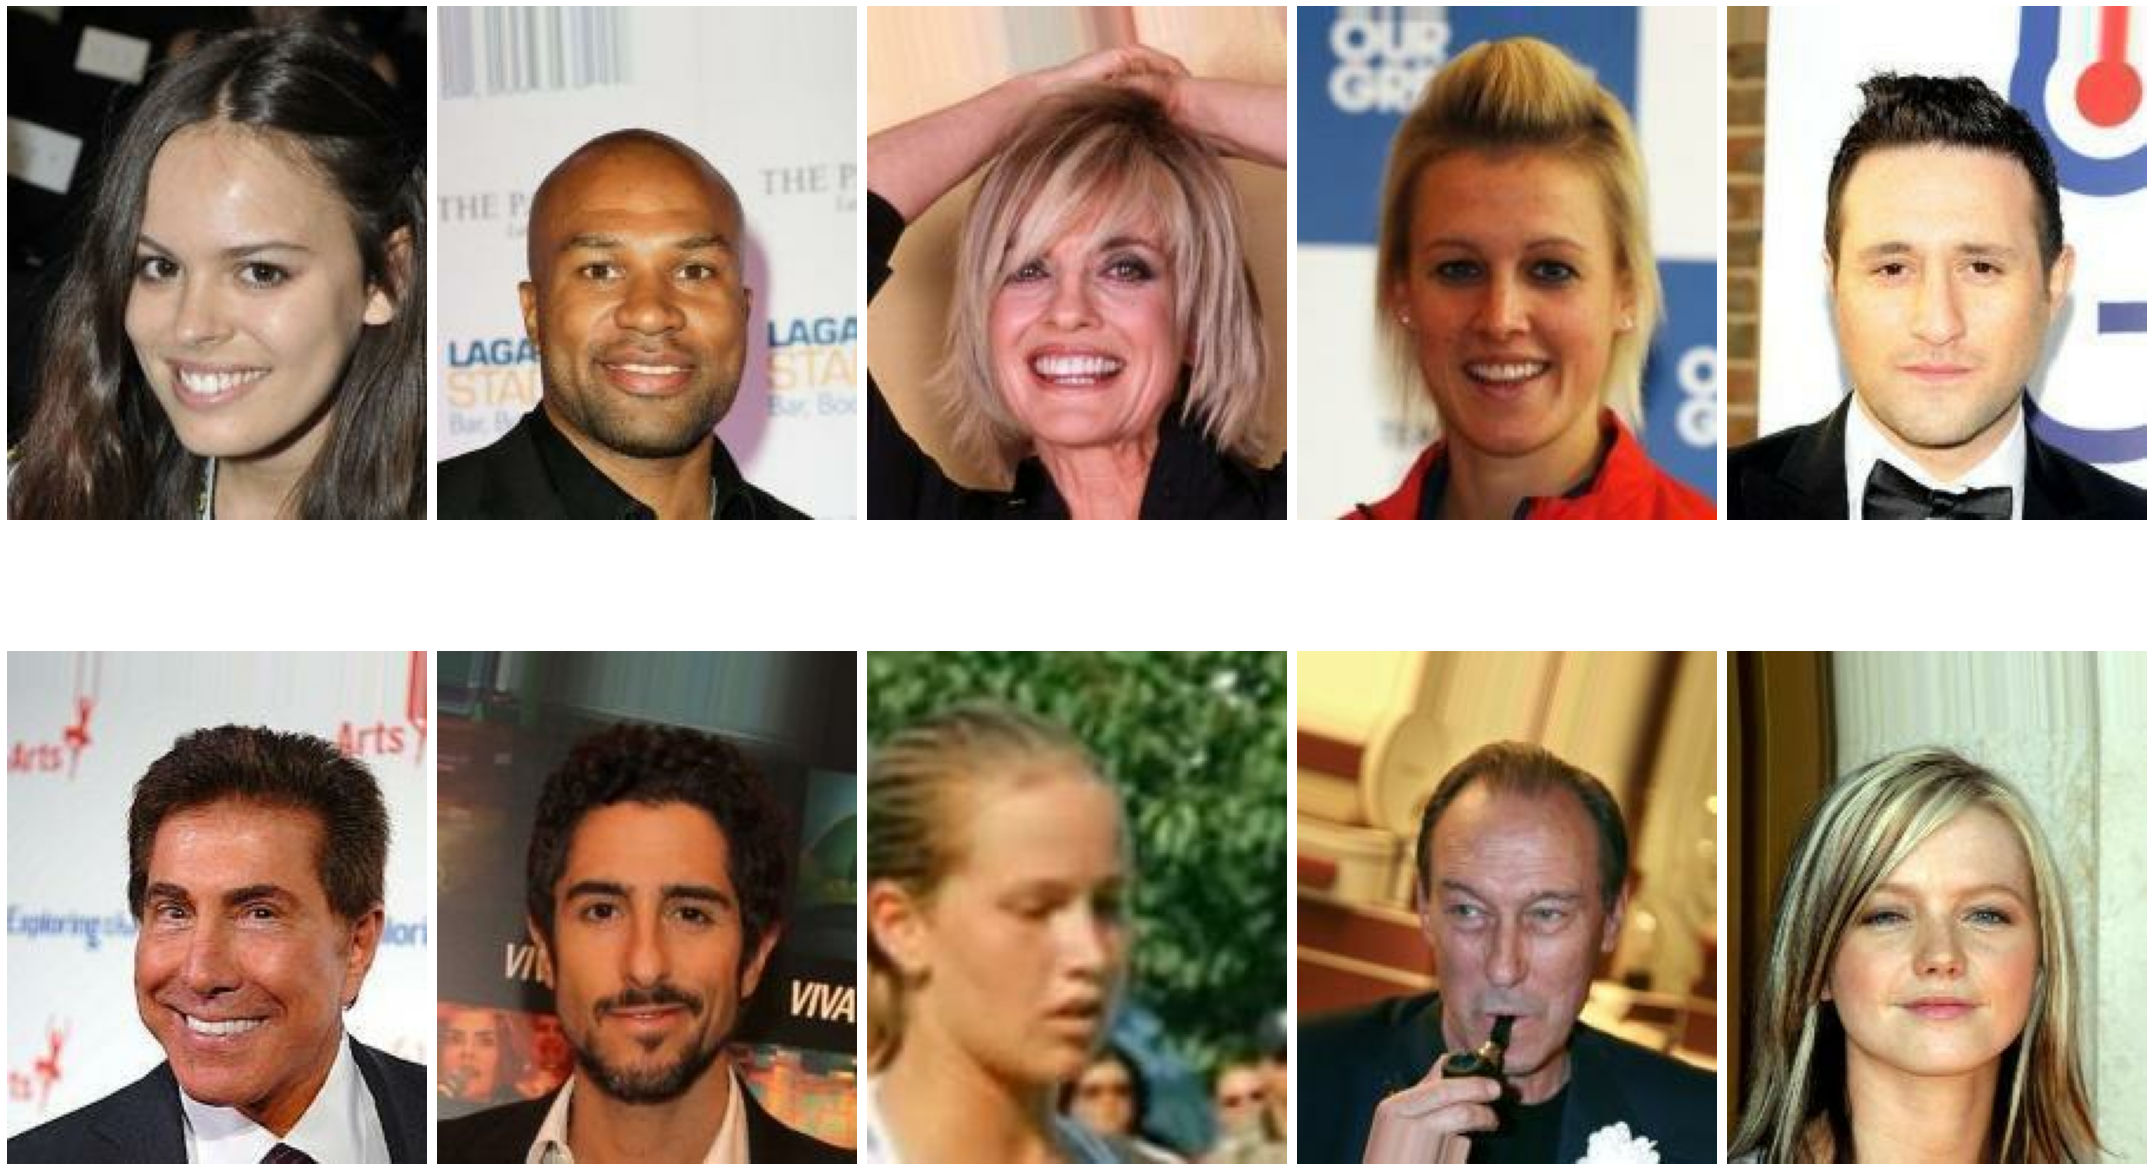

In [7]:
fig = plt.figure(figsize= (30, 20))

for i, item in enumerate (celeba_train.take(10)):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(item['image'])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
def augment_train_images(item, size= (128, 128)):
    image = item['image']
    label = item['attributes']['Male']
    image_cropped = tf.image.random_crop(image, size= (178, 178, 3))
    image_resized = tf.image.resize(image_cropped, size= size)
    image_flipped = tf.image.random_flip_left_right(image_resized)
    return image_flipped/255.0, tf.cast(label, tf.int32)

def augment_valid_images(item, size= (128, 128)):
    image = item['image']
    label = item['attributes']['Male']
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height= 20, offset_width= 0, target_height= 178, target_width= 178)
    image_resized = tf.image.resize(image_cropped, size= size)
    return image_resized/255.0, tf.cast(label, tf.int32)

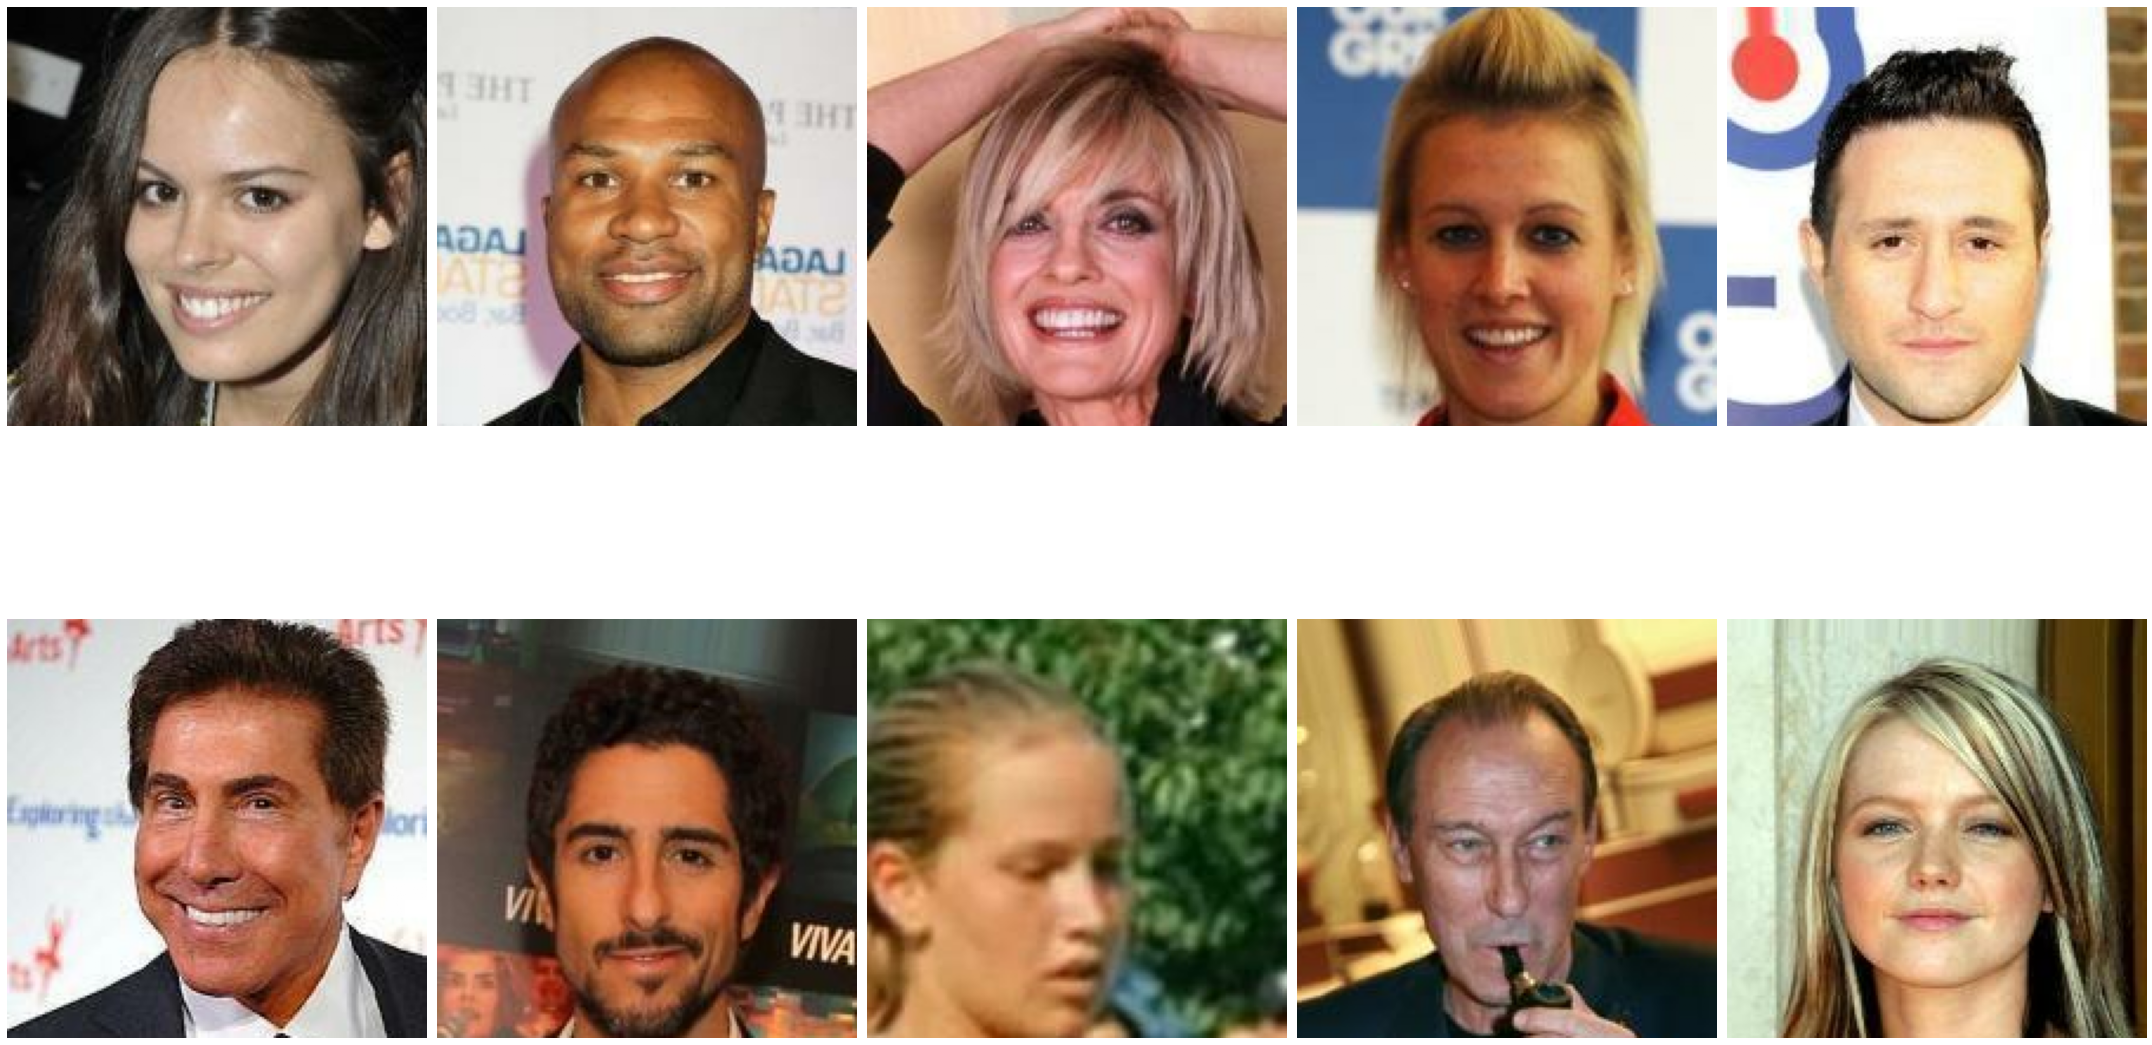

In [9]:
test_augment_ds = celeba_train.take(10)
test_augment_ds =test_augment_ds.map(lambda x: augment_train_images(x, size=(178, 178)))
fig= plt.figure(figsize= (30, 20))
for i, item in enumerate(test_augment_ds):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(item[0])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(len(celeba_train)/ BATCH_SIZE)

ds_train = celeba_train.map(lambda x: augment_train_images(x, size= IMAGE_SIZE))
ds_train = ds_train.shuffle(buffer_size= BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(lambda x: augment_valid_images(x, size= IMAGE_SIZE))
ds_valid = ds_valid.batch(BATCH_SIZE)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding= 'same', activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate= 0.5),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding= 'same', activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate= 0.5),
    
    tf.keras.layers.Conv2D(128, (3, 3), padding= 'same', activation= 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(256, (3, 3), padding= 'same', activation= 'relu')
])

model.add(tf.keras.layers.GlobalAveragePooling2D())
print(model.compute_output_shape(input_shape= (None, 64, 64, 3)))

(None, 256)


In [12]:
model.add(tf.keras.layers.Dense(1, activation= None))
tf.random.set_seed(1)
model.build(input_shape= (None, 64, 64, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

In [13]:
model.compile(optimizer= tf.keras.optimizers.Adam(), loss= tf.keras.losses.BinaryCrossentropy(from_logits= True), metrics= ['accuracy'])

In [14]:
H = model.fit(ds_train, validation_data= ds_valid, epochs= 20, steps_per_epoch= steps_per_epoch)

Epoch 1/20
5087/5087 [==============================] - 277s 52ms/step - loss: 0.5186 - accuracy: 0.7113 - val_loss: 0.1532 - val_accuracy: 0.9397
Epoch 2/20
5087/5087 [==============================] - 266s 52ms/step - loss: 0.2256 - accuracy: 0.8998 - val_loss: 0.1416 - val_accuracy: 0.9283
Epoch 3/20
5087/5087 [==============================] - 266s 52ms/step - loss: 0.1826 - accuracy: 0.9224 - val_loss: 0.1112 - val_accuracy: 0.9462
Epoch 4/20
5087/5087 [==============================] - 266s 52ms/step - loss: 0.1600 - accuracy: 0.9324 - val_loss: 0.0968 - val_accuracy: 0.9547
Epoch 5/20
5087/5087 [==============================] - 266s 52ms/step - loss: 0.1504 - accuracy: 0.9373 - val_loss: 0.0853 - val_accuracy: 0.9644
Epoch 6/20
5087/5087 [==============================] - 265s 52ms/step - loss: 0.1373 - accuracy: 0.9421 - val_loss: 0.0817 - val_accuracy: 0.9669
Epoch 7/20
5087/5087 [==============================] - 260s 51ms/step - loss: 0.1298 - accuracy: 0.9466 - val_loss: 0

In [16]:
model.save('gender_classifier_celeba.h5')